In [1]:
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler

# Load CSVs (features x samples format, so we need to transpose)
gene_df = pd.read_csv("../NewDatasets/processed_expression_FXS_OG.csv", index_col=0).T
meth_df = pd.read_csv("../NewDatasets/processed_methylation_FXS_OG.csv", index_col=0).T
cnv_df  = pd.read_csv("../NewDatasets/processed_cnv_FXS_OG.csv", index_col=0).T
# Filter features by variance threshold (0.1) before standardizing
variance_threshold = 0.1

gene_var = gene_df.var(axis=0)
meth_var = meth_df.var(axis=0)
cnv_var  = cnv_df.var(axis=0)

gene_df = gene_df.loc[:, gene_var > variance_threshold]
meth_df = meth_df.loc[:, meth_var > variance_threshold]
cnv_df  = cnv_df.loc[:, cnv_var  > variance_threshold]

# Apply standard scaling to all data
scaler_meth = StandardScaler()
meth_df = pd.DataFrame(
    scaler_meth.fit_transform(meth_df.T).T,
    index=meth_df.index,
    columns=meth_df.columns
)

scaler_cnv = StandardScaler()
cnv_df = pd.DataFrame(
    scaler_cnv.fit_transform(cnv_df.T).T,
    index=cnv_df.index,
    columns=cnv_df.columns
)

scaler_gene = StandardScaler()
gene_df = pd.DataFrame(
    scaler_gene.fit_transform(gene_df.T).T,
    index=gene_df.index,
    columns=gene_df.columns
)

print("After transpose - Shapes (samples x features):")
print(f"gene_df: {gene_df.shape}")
print(f"meth_df: {meth_df.shape}")
print(f"cnv_df: {cnv_df.shape}")

After transpose - Shapes (samples x features):
gene_df: (205, 18674)
meth_df: (205, 389238)
cnv_df: (205, 56756)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
print("NaN counts:", gene_df.isna().sum().sum(),
      meth_df.isna().sum().sum(),
      cnv_df.isna().sum().sum())


NaN counts: 0 0 0


In [4]:
gene_df = gene_df.fillna(0.0)
meth_df = meth_df.fillna(0.0)
cnv_df  = cnv_df.fillna(0.0)


In [5]:
print("Shapes:", gene_df.shape, meth_df.shape, cnv_df.shape)
# Align samples across all three omics
common = gene_df.index.intersection(meth_df.index).intersection(cnv_df.index)
gene_df = gene_df.loc[common]
meth_df = meth_df.loc[common]
cnv_df  = cnv_df.loc[common]

print("Shapes:", gene_df.shape, meth_df.shape, cnv_df.shape)
# Convert to float32 tensors
gene = torch.tensor(gene_df.values, dtype=torch.float32).to(device)
meth = torch.tensor(meth_df.values, dtype=torch.float32).to(device)
cnv  = torch.tensor(cnv_df.values, dtype=torch.float32).to(device)


Shapes: (205, 18674) (205, 389238) (205, 56756)


Shapes: (205, 18674) (205, 389238) (205, 56756)


Epoch 1/400 | Train Loss: 0.2538 | Val Loss: 0.0075
Epoch 10/400 | Train Loss: 0.1292 | Val Loss: 0.0025
Epoch 20/400 | Train Loss: 0.0724 | Val Loss: 0.0031
Epoch 10/400 | Train Loss: 0.1292 | Val Loss: 0.0025
Epoch 20/400 | Train Loss: 0.0724 | Val Loss: 0.0031
Early stopping triggered!
Early stopping triggered!


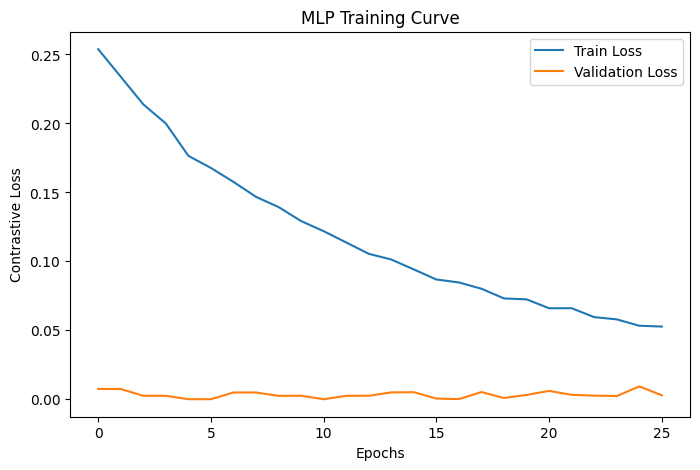

Epoch 1/400 | Train Loss: 0.2465 | Val Loss: 0.0003
Epoch 10/400 | Train Loss: 0.1163 | Val Loss: 0.0025
Epoch 10/400 | Train Loss: 0.1163 | Val Loss: 0.0025
Epoch 20/400 | Train Loss: 0.0608 | Val Loss: 0.0058
Epoch 20/400 | Train Loss: 0.0608 | Val Loss: 0.0058
Early stopping triggered!
Early stopping triggered!


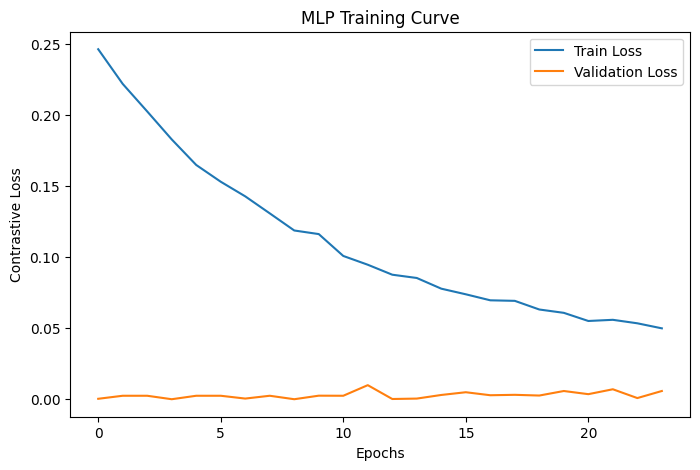

Epoch 1/400 | Train Loss: 0.2475 | Val Loss: 0.0002
Epoch 10/400 | Train Loss: 0.1432 | Val Loss: 0.0049
Epoch 10/400 | Train Loss: 0.1432 | Val Loss: 0.0049
Epoch 20/400 | Train Loss: 0.0848 | Val Loss: 0.0073
Epoch 20/400 | Train Loss: 0.0848 | Val Loss: 0.0073
Epoch 30/400 | Train Loss: 0.0559 | Val Loss: 0.0001
Early stopping triggered!
Epoch 30/400 | Train Loss: 0.0559 | Val Loss: 0.0001
Early stopping triggered!


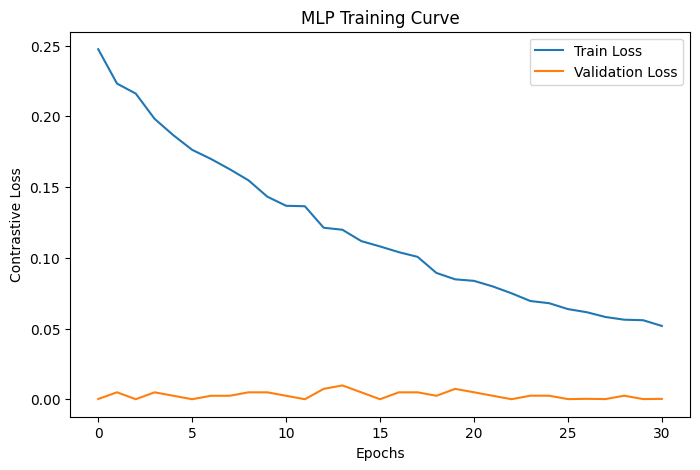

Individual latent shapes:
  - Gene latent: torch.Size([205, 64])
  - Methylation latent: torch.Size([205, 64])
  - CNV latent: torch.Size([205, 64])


In [6]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler

# ------------------ MLP Feature Extractor with Dropout ------------------
class MLP(nn.Module):
    def __init__(self, input_dim, latent_dim=64, dropout=0.3):
        super(MLP, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, latent_dim)
        )

    def forward(self, x):
        return self.feature_extractor(x)

# ------------------ Training with contrastive learning approach ------------------
def train_mlp(model, data, epochs=400, patience=15, normalize=True):
    # Optionally normalize features to mean=0, std=1
    if normalize:
        scaler = StandardScaler()
        data_np = scaler.fit_transform(data.cpu().numpy())
    else:
        data_np = data.cpu().numpy()

    # Split into train/val
    X_train, X_val = train_test_split(data_np, test_size=0.2, random_state=42)
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_val   = torch.tensor(X_val, dtype=torch.float32).to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    
    # For unsupervised feature learning, we use a simple contrastive approach
    # We create positive pairs by adding small noise and negative pairs from different samples
    def create_pairs(X, noise_std=0.1):
        # Positive pairs: original + noisy version
        noise = torch.randn_like(X) * noise_std
        X_pos = X + noise
        
        # Negative pairs: random shuffle
        idx = torch.randperm(X.size(0))
        X_neg = X[idx]
        
        return X_pos, X_neg

    train_losses, val_losses = [], []
    best_val_loss = np.inf
    best_model_state = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        
        # Create positive and negative pairs
        X_pos, X_neg = create_pairs(X_train)
        
        # Get embeddings
        z_orig = model(X_train)
        z_pos = model(X_pos)
        z_neg = model(X_neg)
        
        # Contrastive loss: pull positive pairs together, push negative pairs apart
        pos_loss = torch.mean((z_orig - z_pos) ** 2)
        neg_loss = torch.mean(torch.clamp(1.0 - torch.norm(z_orig - z_neg, dim=1), min=0) ** 2)
        loss = pos_loss + 0.1 * neg_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Validation - use same approach
        model.eval()
        with torch.no_grad():
            X_val_pos, X_val_neg = create_pairs(X_val)
            z_val_orig = model(X_val)
            z_val_pos = model(X_val_pos)
            z_val_neg = model(X_val_neg)
            
            val_pos_loss = torch.mean((z_val_orig - z_val_pos) ** 2)
            val_neg_loss = torch.mean(torch.clamp(1.0 - torch.norm(z_val_orig - z_val_neg, dim=1), min=0) ** 2)
            val_loss = val_pos_loss + 0.1 * val_neg_loss

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

        # Early stopping
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

    # Restore best model
    if best_model_state:
        model.load_state_dict(best_model_state)

    # Plot loss curves
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Contrastive Loss")
    plt.title("MLP Training Curve")
    plt.legend()
    plt.show()

    return model

# ------------------ Train per omic ------------------
gene_dim, meth_dim, cnv_dim = gene.shape[1], meth.shape[1], cnv.shape[1]

mlp_gene = MLP(gene_dim, latent_dim=64).to(device)
mlp_meth = MLP(meth_dim, latent_dim=64).to(device)
mlp_cnv  = MLP(cnv_dim,  latent_dim=64).to(device)

mlp_gene = train_mlp(mlp_gene, gene, normalize=True)
mlp_meth = train_mlp(mlp_meth, meth, normalize=True)
mlp_cnv  = train_mlp(mlp_cnv, cnv, normalize=True)

# ------------------ Extract latent embeddings (NO FUSION) ------------------
mlp_gene.eval(); mlp_meth.eval(); mlp_cnv.eval()
with torch.no_grad():
    z_gene = mlp_gene(gene.to(device))
    z_meth = mlp_meth(meth.to(device))
    z_cnv  = mlp_cnv(cnv.to(device))

print("Individual latent shapes:")
print(f"  - Gene latent: {z_gene.shape}")
print(f"  - Methylation latent: {z_meth.shape}")
print(f"  - CNV latent: {z_cnv.shape}")


# Individual Omics Machine Learning Evaluation

Train multiple classifiers on each individual omic's latent embeddings separately and compare performance.

In [7]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score)
import seaborn as sns

# Load subtype labels
labels_df = pd.read_csv("../NewDatasets/processed_labels_3Omics_FXS_OG.csv", index_col=0)

# Align labels with our data
common_samples = gene_df.index.intersection(labels_df.index)
print(f"Samples with labels: {len(common_samples)}")

# Get labels
labels = labels_df.loc[common_samples].values.ravel()

print(f"Labels shape: {labels.shape}")
print(f"Unique classes: {np.unique(labels)}")
print(f"Class distribution: {np.bincount(labels.astype(int))}")

# Prepare individual omics embeddings
omics_data = {
    'Gene Expression': z_gene.cpu().numpy(),
    'Methylation': z_meth.cpu().numpy(),
    'Copy Number Variation': z_cnv.cpu().numpy()
}

print("\nIndividual omics embedding shapes:")
for name, data in omics_data.items():
    print(f"  {name}: {data.shape}")

Samples with labels: 205
Labels shape: (205,)
Unique classes: [0 1 2 3]
Class distribution: [53 22 96 34]

Individual omics embedding shapes:
  Gene Expression: (205, 64)
  Methylation: (205, 64)
  Copy Number Variation: (205, 64)


# Individual Omics MLP Analysis

Analyzing the extracted embeddings from individual omics MLPs.

In [8]:
# C-index calculation function (same as AE pipeline)
from sklearn.metrics import roc_auc_score

def concordance_index(y_true, y_pred_proba):
    """
    Calculate C-index (Concordance Index) for multi-class classification.
    Uses macro-averaged AUC for multi-class problems.
    """
    try:
        # For multi-class, use macro-averaged AUC as C-index
        c_index = roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='macro')
        return c_index
    except:
        return 0.0

print("="*100)
print("INDIVIDUAL OMICS MLP EMBEDDINGS ANALYSIS")
print("="*100)

# Display embedding statistics
for omic_name, omic_data in omics_data.items():
    print(f"\n{omic_name} Embeddings:")
    print(f"  Shape: {omic_data.shape}")
    print(f"  Mean: {omic_data.mean():.4f}")
    print(f"  Std: {omic_data.std():.4f}")
    print(f"  Min: {omic_data.min():.4f}")
    print(f"  Max: {omic_data.max():.4f}")

print("\n✅ MLP embeddings analysis completed!")

INDIVIDUAL OMICS MLP EMBEDDINGS ANALYSIS

Gene Expression Embeddings:
  Shape: (205, 64)
  Mean: -0.0081
  Std: 0.2098
  Min: -0.5668
  Max: 0.7517

Methylation Embeddings:
  Shape: (205, 64)
  Mean: 0.0437
  Std: 0.1690
  Min: -0.4494
  Max: 0.6204

Copy Number Variation Embeddings:
  Shape: (205, 64)
  Mean: -0.0035
  Std: 0.1588
  Min: -0.7546
  Max: 0.6192

✅ MLP embeddings analysis completed!


COMPREHENSIVE INDIVIDUAL OMICS EMBEDDINGS VISUALIZATION

📊 Processing Gene Expression...
Computing PCA for Gene Expression...
Computing t-SNE for Gene Expression...


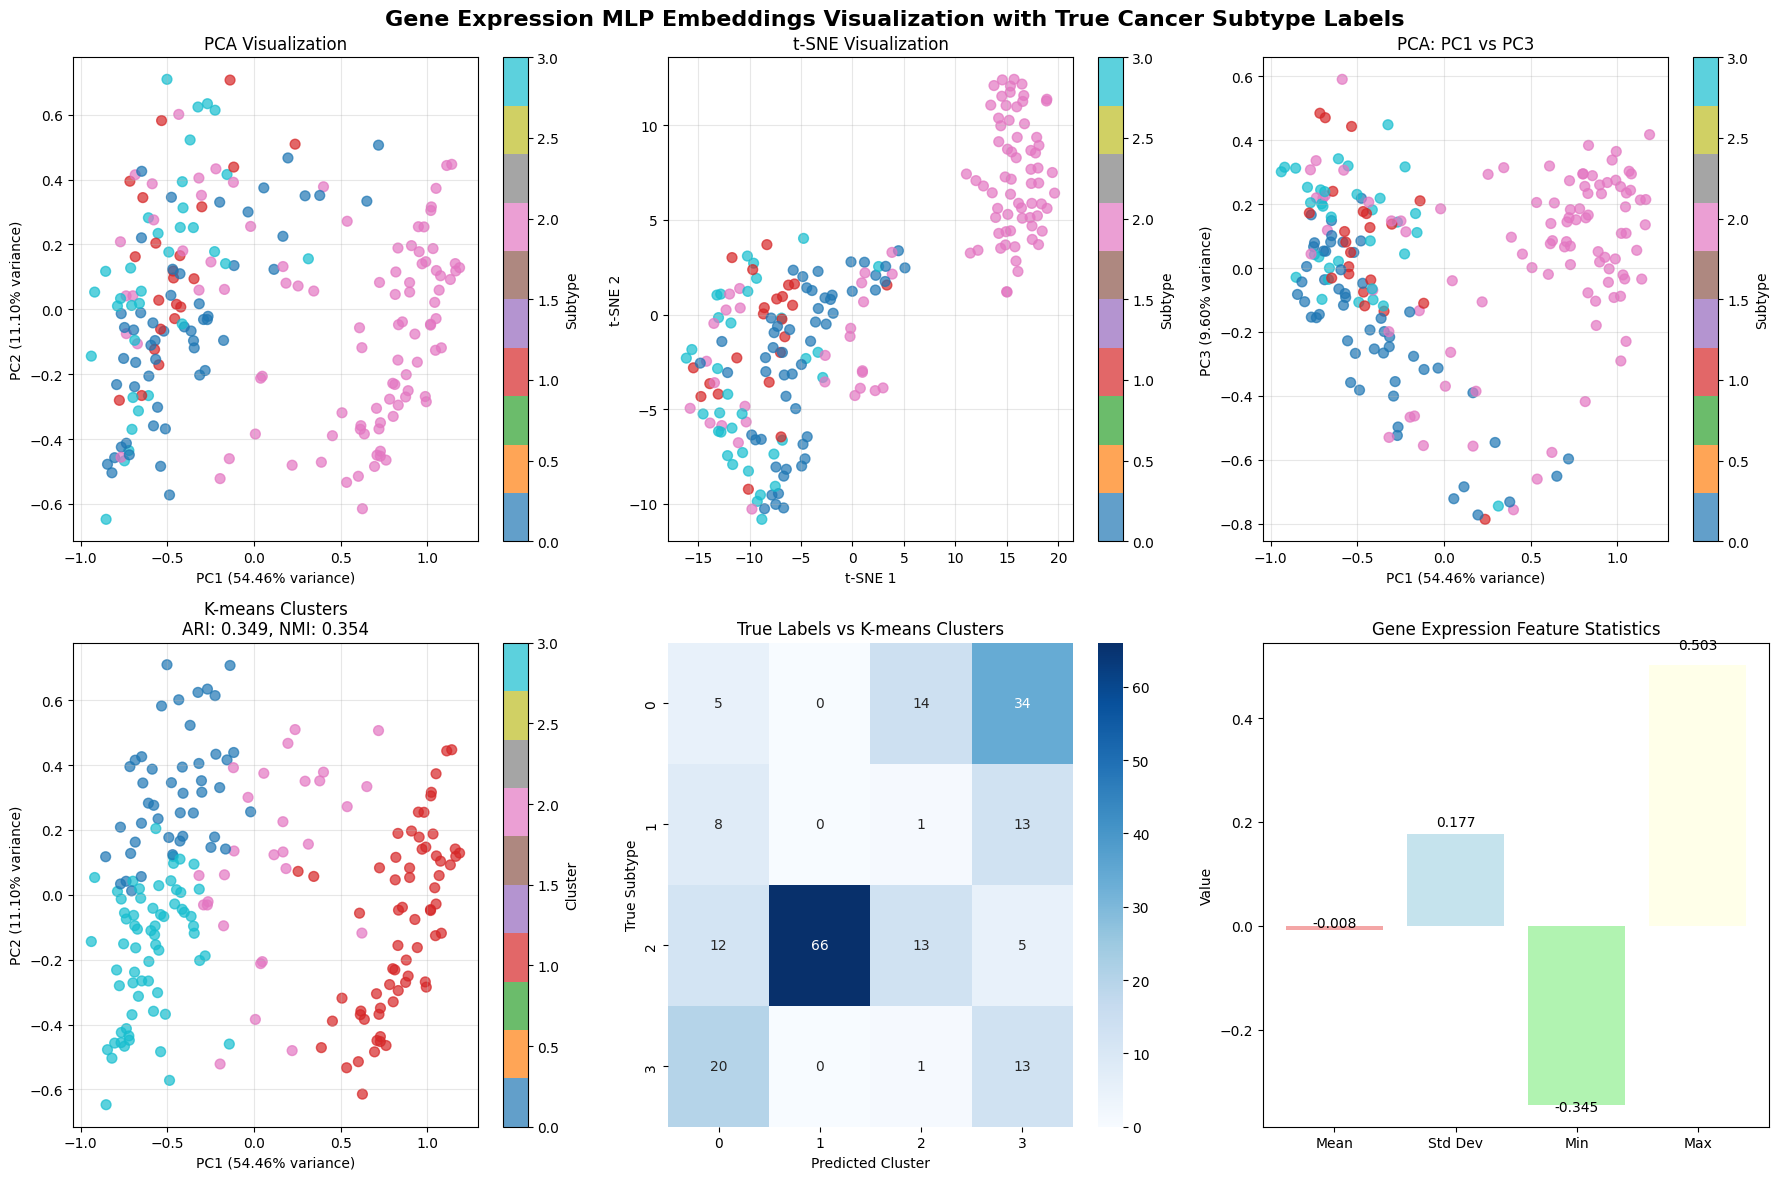


📊 Processing Methylation...
Computing PCA for Methylation...
Computing t-SNE for Methylation...


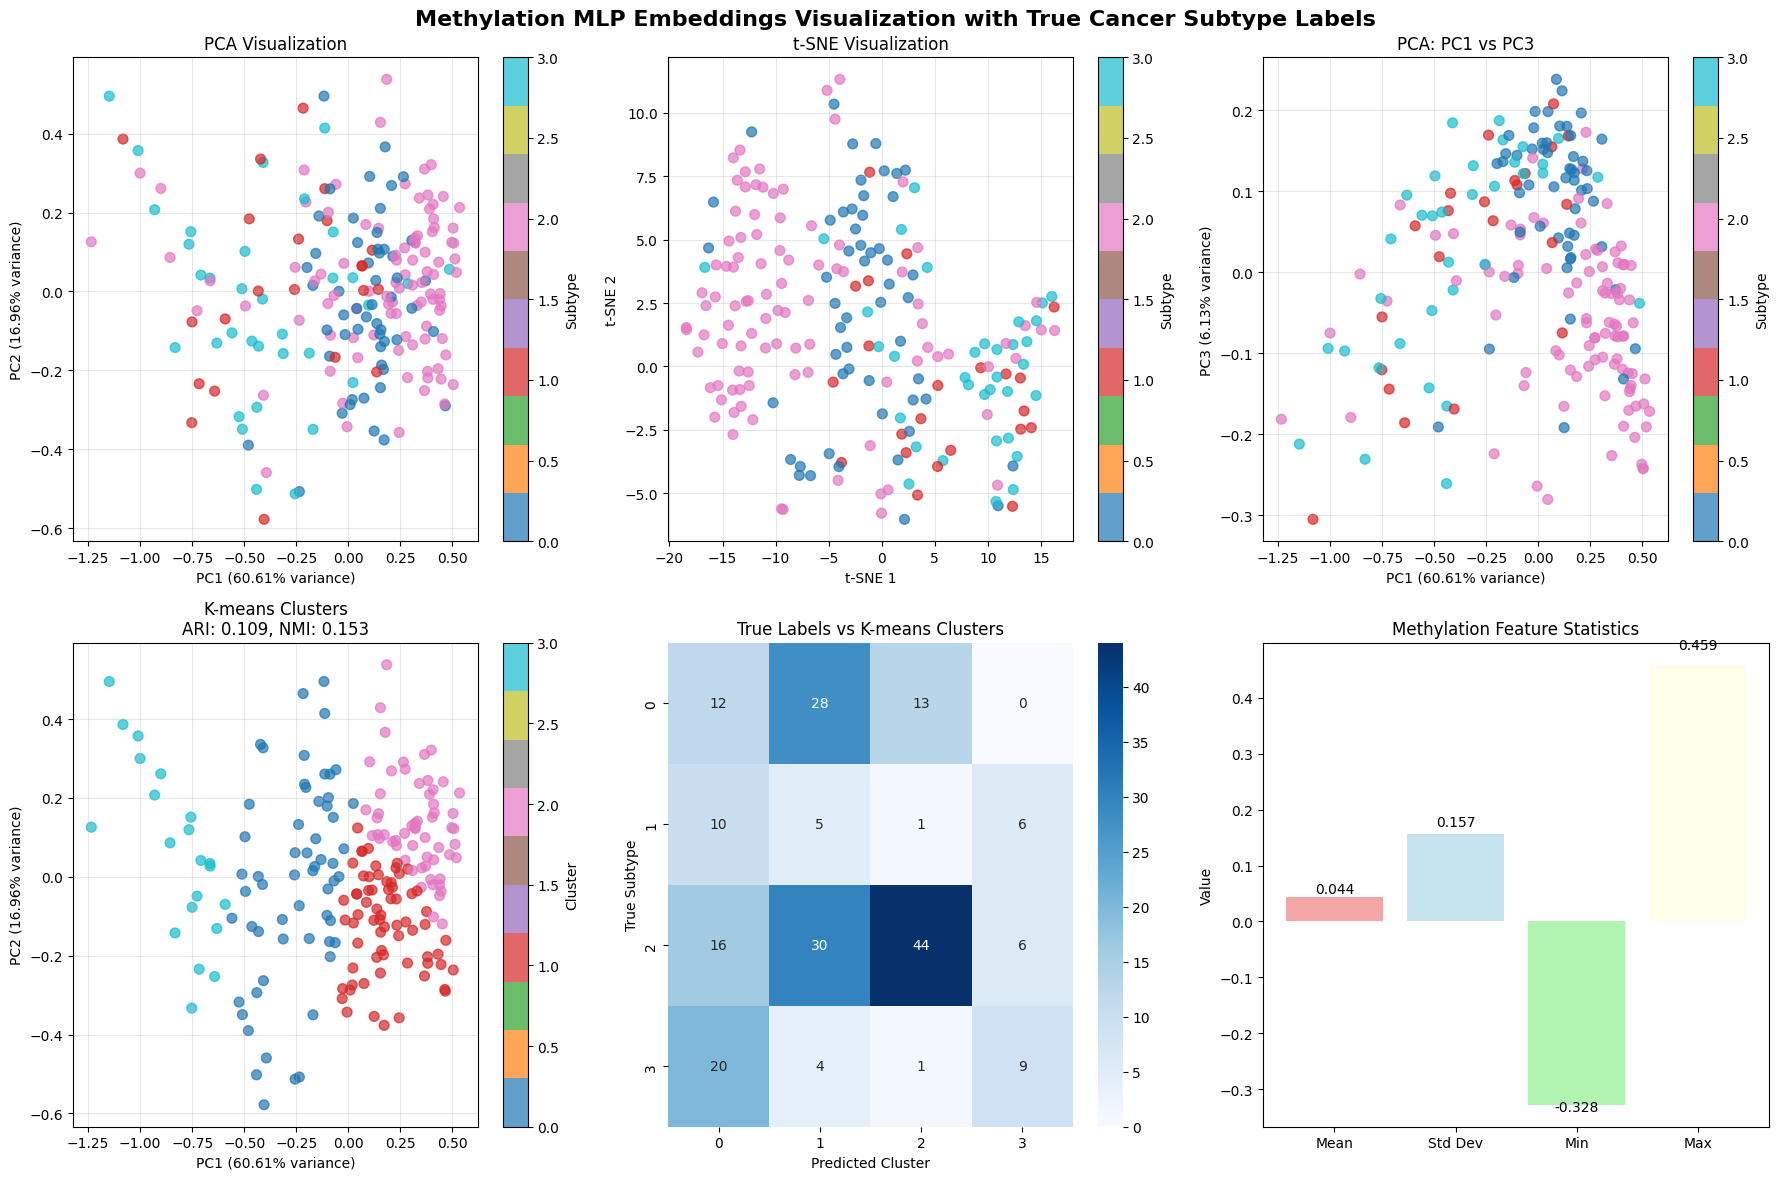


📊 Processing Copy Number Variation...
Computing PCA for Copy Number Variation...
Computing t-SNE for Copy Number Variation...


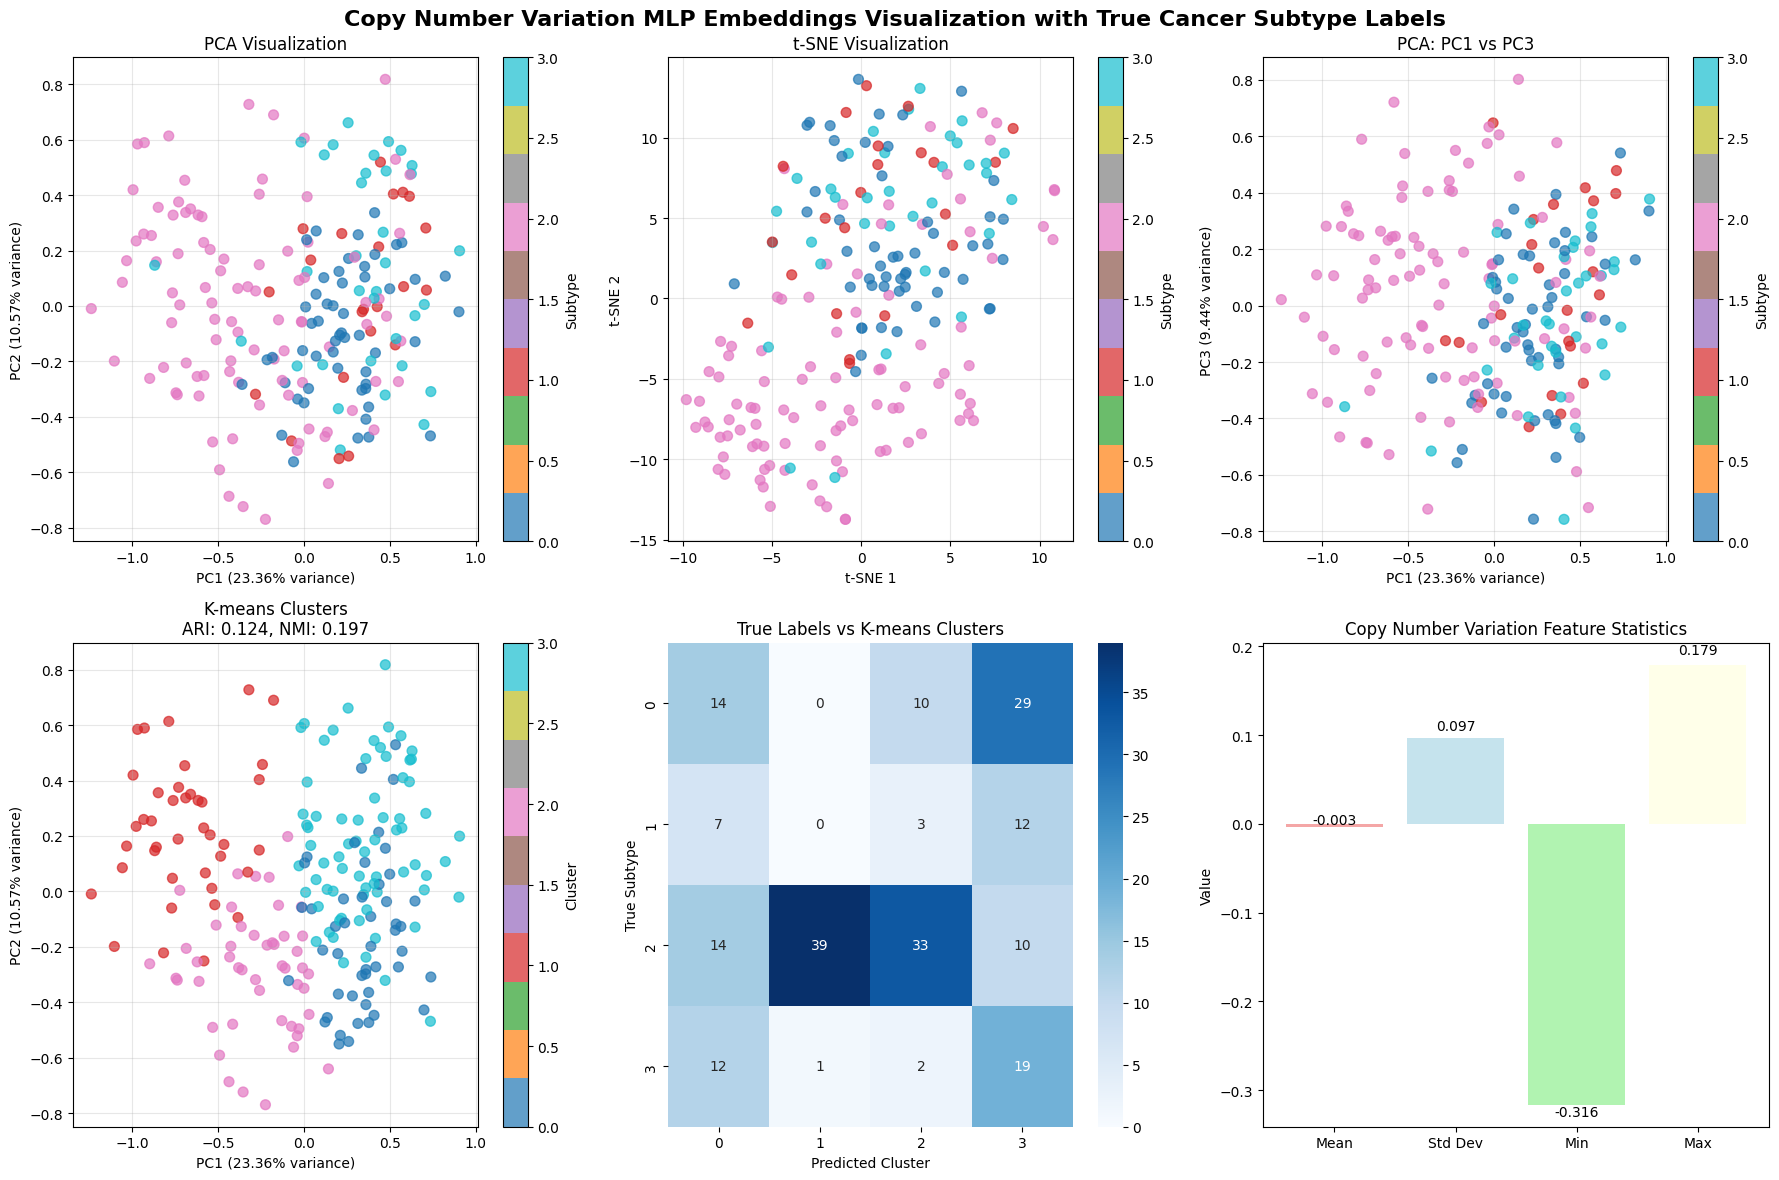

✅ Comprehensive individual omics embeddings visualization completed!


In [9]:
# Comprehensive Embedding Visualization for Each Omic (same as AE pipeline)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("="*100)
print("COMPREHENSIVE INDIVIDUAL OMICS EMBEDDINGS VISUALIZATION")
print("="*100)

# Process each omic separately with comprehensive visualization
for omic_name, omic_data in omics_data.items():
    print(f"\n📊 Processing {omic_name}...")
    
    # Create comprehensive visualization for this omic
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'{omic_name} MLP Embeddings Visualization with True Cancer Subtype Labels', fontsize=16, fontweight='bold')

    # 1. PCA 2D visualization
    print(f"Computing PCA for {omic_name}...")
    pca_2d = PCA(n_components=2, random_state=42)
    embeddings_pca_2d = pca_2d.fit_transform(omic_data)

    scatter1 = axes[0, 0].scatter(embeddings_pca_2d[:, 0], embeddings_pca_2d[:, 1], 
                                 c=labels, cmap='tab10', alpha=0.7, s=50)
    axes[0, 0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
    axes[0, 0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
    axes[0, 0].set_title('PCA Visualization')
    axes[0, 0].grid(True, alpha=0.3)
    plt.colorbar(scatter1, ax=axes[0, 0], label='Subtype')

    # 2. t-SNE 2D visualization
    print(f"Computing t-SNE for {omic_name}...")
    tsne_2d = TSNE(n_components=2, random_state=42, perplexity=30)
    embeddings_tsne_2d = tsne_2d.fit_transform(omic_data)

    scatter2 = axes[0, 1].scatter(embeddings_tsne_2d[:, 0], embeddings_tsne_2d[:, 1], 
                                 c=labels, cmap='tab10', alpha=0.7, s=50)
    axes[0, 1].set_xlabel('t-SNE 1')
    axes[0, 1].set_ylabel('t-SNE 2')
    axes[0, 1].set_title('t-SNE Visualization')
    axes[0, 1].grid(True, alpha=0.3)
    plt.colorbar(scatter2, ax=axes[0, 1], label='Subtype')

    # 3. PCA 3D to 2D projections (PC1 vs PC3)
    pca_3d = PCA(n_components=3, random_state=42)
    embeddings_pca_3d = pca_3d.fit_transform(omic_data)

    scatter3 = axes[0, 2].scatter(embeddings_pca_3d[:, 0], embeddings_pca_3d[:, 2], 
                                 c=labels, cmap='tab10', alpha=0.7, s=50)
    axes[0, 2].set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2%} variance)')
    axes[0, 2].set_ylabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2%} variance)')
    axes[0, 2].set_title('PCA: PC1 vs PC3')
    axes[0, 2].grid(True, alpha=0.3)
    plt.colorbar(scatter3, ax=axes[0, 2], label='Subtype')

    # 4. Cluster analysis comparison
    n_clusters = len(np.unique(labels))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    predicted_clusters = kmeans.fit_predict(omic_data)

    # Calculate clustering metrics
    ari_score = adjusted_rand_score(labels, predicted_clusters)
    nmi_score = normalized_mutual_info_score(labels, predicted_clusters)

    scatter4 = axes[1, 0].scatter(embeddings_pca_2d[:, 0], embeddings_pca_2d[:, 1], 
                                 c=predicted_clusters, cmap='tab10', alpha=0.7, s=50)
    axes[1, 0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
    axes[1, 0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
    axes[1, 0].set_title(f'K-means Clusters\nARI: {ari_score:.3f}, NMI: {nmi_score:.3f}')
    axes[1, 0].grid(True, alpha=0.3)
    plt.colorbar(scatter4, ax=axes[1, 0], label='Cluster')

    # 5. Confusion matrix: True vs Predicted
    cm = confusion_matrix(labels, predicted_clusters)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
    axes[1, 1].set_xlabel('Predicted Cluster')
    axes[1, 1].set_ylabel('True Subtype')
    axes[1, 1].set_title('True Labels vs K-means Clusters')

    # 6. Feature statistics
    feature_stats = {
        'Mean': np.mean(omic_data, axis=0).mean(),
        'Std Dev': np.mean(omic_data, axis=0).std(),
        'Min': np.mean(omic_data, axis=0).min(),
        'Max': np.mean(omic_data, axis=0).max()
    }
    
    bars = axes[1, 2].bar(feature_stats.keys(), feature_stats.values(), 
                          alpha=0.7, color=['lightcoral', 'lightblue', 'lightgreen', 'lightyellow'])
    axes[1, 2].set_ylabel('Value')
    axes[1, 2].set_title(f'{omic_name} Feature Statistics')
    
    # Add value labels on bars
    for bar, (key, val) in zip(bars, feature_stats.items()):
        axes[1, 2].text(bar.get_x() + bar.get_width()/2., bar.get_height() + bar.get_height()*0.05,
                        f'{val:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

print("✅ Comprehensive individual omics embeddings visualization completed!")

In [10]:
# Traditional ML Classification for Each Omic Separately (same as AE pipeline)
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, classification_report, confusion_matrix)

print("\n" + "="*100)
print("📊 TRADITIONAL ML CLASSIFICATION ON INDIVIDUAL OMICS")
print("="*100)

# Define classifiers (same as AE pipeline)
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5),
    'SVM (RBF)': SVC(kernel='rbf', random_state=42, probability=True),
    'SVM (Linear)': SVC(kernel='linear', random_state=42, probability=True),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr'),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42)
}

# Store results for each omic separately
omic_results = {}

# Process each omic separately
for omic_name, omic_data in omics_data.items():
    print(f"\n{'='*100}")
    print(f"🧬 PROCESSING: {omic_name}")
    print(f"{'='*100}")
    
    # Split data for this omic
    X_train, X_test, y_train, y_test = train_test_split(
        omic_data, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    print(f"Training set size: {X_train.shape[0]}")
    print(f"Test set size: {X_test.shape[0]}")
    print(f"Training class distribution: {np.bincount(y_train.astype(int))}")
    print(f"Test class distribution: {np.bincount(y_test.astype(int))}")
    
    # Store results for this omic
    results = []
    
    print(f"\nTraining and evaluating classifiers for {omic_name}...")
    print("-" * 80)
    
    for name, clf in classifiers.items():
        # Train the model
        clf.fit(X_train, y_train)
        
        # Make predictions
        y_pred = clf.predict(X_test)
        y_pred_proba = clf.predict_proba(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
        precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
        recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
        recall_micro = recall_score(y_test, y_pred, average='micro', zero_division=0)
        f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
        f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
        c_index = concordance_index(y_test, y_pred_proba)
        
        # Store results
        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'Precision (Macro)': precision_macro,
            'Precision (Micro)': precision_micro,
            'Recall (Macro)': recall_macro,
            'Recall (Micro)': recall_micro,
            'F1 (Macro)': f1_macro,
            'F1 (Micro)': f1_micro,
            'C-Index': c_index
        })
    
    # Store results for this omic
    omic_results[omic_name] = {
        'results': results,
        'X_train': X_train,
        'X_test': X_test, 
        'y_train': y_train,
        'y_test': y_test,
        'classifiers': classifiers
    }
    
    print(f"✅ {omic_name} classification completed!")

print(f"\n{'='*100}")
print("✅ All individual omics classification completed!")
print(f"{'='*100}")


📊 TRADITIONAL ML CLASSIFICATION ON INDIVIDUAL OMICS

🧬 PROCESSING: Gene Expression
Training set size: 164
Test set size: 41
Training class distribution: [42 18 77 27]
Test class distribution: [11  4 19  7]

Training and evaluating classifiers for Gene Expression...
--------------------------------------------------------------------------------


f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ Gene Expression classification completed!

🧬 PROCESSING: Methylation
Training set size: 164
Test set size: 41
Training class distribution: [42 18 77 27]
Test class distribution: [11  4 19  7]

Training and evaluating classifiers for Methylation...
--------------------------------------------------------------------------------


f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ Methylation classification completed!

🧬 PROCESSING: Copy Number Variation
Training set size: 164
Test set size: 41
Training class distribution: [42 18 77 27]
Test class distribution: [11  4 19  7]

Training and evaluating classifiers for Copy Number Variation...
--------------------------------------------------------------------------------
✅ Copy Number Variation classification completed!

✅ All individual omics classification completed!
✅ Copy Number Variation classification completed!

✅ All individual omics classification completed!


f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [11]:
# Native MLP Classifiers for Each Omic (same hyperparameters as AE pipeline)
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dims=[128, 64], dropout=0.3):
        super(MLPClassifier, self).__init__()
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.BatchNorm1d(hidden_dims[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))
        
        # Hidden layers
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.BatchNorm1d(hidden_dims[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        
        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], num_classes))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

def train_mlp_classifier(model, X_train, y_train, X_test, y_test, epochs=200, patience=15):
    """Train MLP classifier with early stopping (same as AE pipeline)"""
    # Convert to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)
    
    # Create data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    best_test_acc = 0
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()
        
        # Testing
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs, y_test_tensor)
            _, test_predicted = torch.max(test_outputs.data, 1)
            test_acc = (test_predicted == y_test_tensor).sum().item() / len(y_test_tensor)
        
        train_acc = train_correct / train_total
        scheduler.step(test_loss)
        
        if (epoch + 1) % 50 == 0:
            print(f'  Epoch [{epoch+1}/{epochs}], Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        
        # Early stopping
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"  Early stopping at epoch {epoch+1}")
                break
    
    # Restore best model
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    return model

print("\n" + "="*100)
print("🤖 NATIVE MLP CLASSIFIERS FOR INDIVIDUAL OMICS")
print("="*100)

num_classes = len(np.unique(labels))

# Train native MLP classifiers for each omic
for omic_name, omic_data in omics_data.items():
    print(f"\n{'='*100}")
    print(f"🤖 TRAINING NATIVE MLP CLASSIFIERS: {omic_name}")
    print(f"{'='*100}")
    
    # Get train/test splits for this omic
    X_train = omic_results[omic_name]['X_train']
    X_test = omic_results[omic_name]['X_test']
    y_train = omic_results[omic_name]['y_train']
    y_test = omic_results[omic_name]['y_test']
    
    input_dim = omic_data.shape[1]
    
    print("Training Native MLP Classifiers...")
    print("-" * 50)
    
    # Shallow MLP Classifier
    shallow_mlp = MLPClassifier(input_dim, num_classes, hidden_dims=[64], dropout=0.2).to(device)
    print(f"Training Shallow MLP Classifier for {omic_name}...")
    shallow_mlp = train_mlp_classifier(shallow_mlp, X_train, y_train, X_test, y_test)
    
    # Deep MLP Classifier  
    deep_mlp = MLPClassifier(input_dim, num_classes, hidden_dims=[256, 128, 64], dropout=0.3).to(device)
    print(f"\nTraining Deep MLP Classifier for {omic_name}...")
    deep_mlp = train_mlp_classifier(deep_mlp, X_train, y_train, X_test, y_test)
    
    # Evaluate MLP classifiers
    def evaluate_mlp_classifier(model, X_test, y_test, model_name):
        """Evaluate MLP classifier and return metrics"""
        model.eval()
        with torch.no_grad():
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
            outputs = model(X_test_tensor)
            _, predicted = torch.max(outputs.data, 1)
            y_pred = predicted.cpu().numpy()
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
        precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
        recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
        recall_micro = recall_score(y_test, y_pred, average='micro', zero_division=0)
        f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
        f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
        
        return {
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision (Macro)': precision_macro,
            'Precision (Micro)': precision_micro,
            'Recall (Macro)': recall_macro,
            'Recall (Micro)': recall_micro,
            'F1 (Macro)': f1_macro,
            'F1 (Micro)': f1_micro
        }
    
    # Evaluate models
    mlp_results = []
    mlp_results.append(evaluate_mlp_classifier(shallow_mlp, X_test, y_test, "Shallow MLP"))
    mlp_results.append(evaluate_mlp_classifier(deep_mlp, X_test, y_test, "Deep MLP"))
    
    # Add MLP results to omic results
    omic_results[omic_name]['mlp_results'] = mlp_results
    
    print(f"✅ {omic_name} native MLP classifiers completed!")

print(f"\n{'='*100}")
print("✅ All native MLP classifiers completed!")
print(f"{'='*100}")


🤖 NATIVE MLP CLASSIFIERS FOR INDIVIDUAL OMICS

🤖 TRAINING NATIVE MLP CLASSIFIERS: Gene Expression
Training Native MLP Classifiers...
--------------------------------------------------
Training Shallow MLP Classifier for Gene Expression...
  Early stopping at epoch 31

Training Deep MLP Classifier for Gene Expression...
  Early stopping at epoch 31

Training Deep MLP Classifier for Gene Expression...
  Early stopping at epoch 24
✅ Gene Expression native MLP classifiers completed!

🤖 TRAINING NATIVE MLP CLASSIFIERS: Methylation
Training Native MLP Classifiers...
--------------------------------------------------
Training Shallow MLP Classifier for Methylation...
  Early stopping at epoch 24
✅ Gene Expression native MLP classifiers completed!

🤖 TRAINING NATIVE MLP CLASSIFIERS: Methylation
Training Native MLP Classifiers...
--------------------------------------------------
Training Shallow MLP Classifier for Methylation...
  Early stopping at epoch 35

Training Deep MLP Classifier for M


📊 COMPREHENSIVE RESULTS FOR EACH OMIC TYPE

🧬 GENE EXPRESSION - COMPLETE RESULTS

📋 TRADITIONAL ML RESULTS - Gene Expression
----------------------------------------------------------------------------------------------------
              Model  Accuracy  Precision (Macro)  Precision (Micro)  Recall (Macro)  Recall (Micro)  F1 (Macro)  F1 (Micro)  C-Index
       SVM (Linear)  0.780488           0.799603           0.780488        0.669301        0.780488    0.672361    0.780488 0.909846
Logistic Regression  0.780488           0.795635           0.780488        0.656314        0.780488    0.664895    0.780488 0.928139
        Naive Bayes  0.780488           0.718254           0.780488        0.735860        0.780488    0.709953    0.780488 0.916837
      Random Forest  0.756098           0.543831           0.756098        0.584245        0.756098    0.562879    0.756098 0.911839
          SVM (RBF)  0.756098           0.545139           0.756098        0.616370        0.756098    0.570

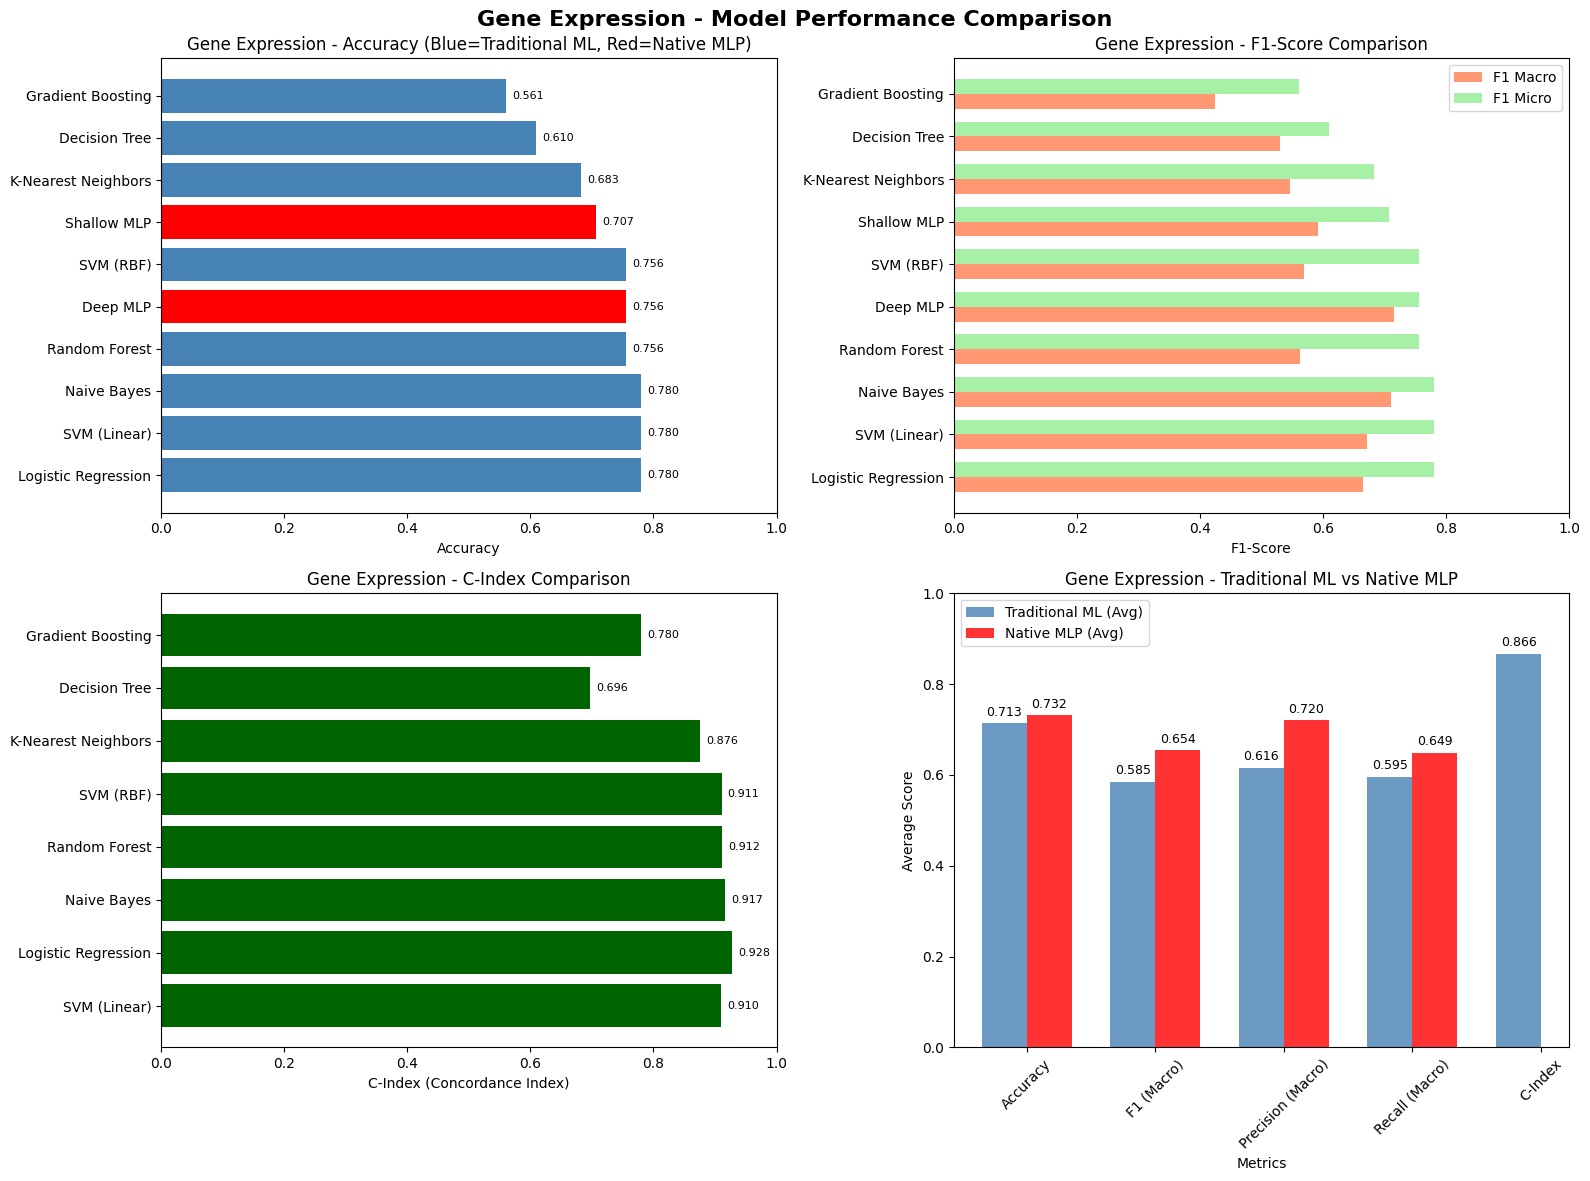


🏆 BEST MODEL FOR Gene Expression: Logistic Regression
   • Accuracy: 0.7805
   • F1-Macro: 0.6649
   • C-Index: 0.9281

🧬 METHYLATION - COMPLETE RESULTS

📋 TRADITIONAL ML RESULTS - Methylation
----------------------------------------------------------------------------------------------------
              Model  Accuracy  Precision (Macro)  Precision (Micro)  Recall (Macro)  Recall (Micro)  F1 (Macro)  F1 (Micro)  C-Index
        Naive Bayes  0.756098           0.628968           0.756098        0.633587        0.756098    0.630739    0.756098 0.816726
      Random Forest  0.731707           0.505952           0.731707        0.561517        0.731707    0.532246    0.731707 0.862375
  Gradient Boosting  0.707317           0.601515           0.707317        0.575145        0.707317    0.584606    0.707317 0.861412
K-Nearest Neighbors  0.682927           0.634524           0.682927        0.588773        0.682927    0.598894    0.682927 0.836724
          SVM (RBF)  0.658537           

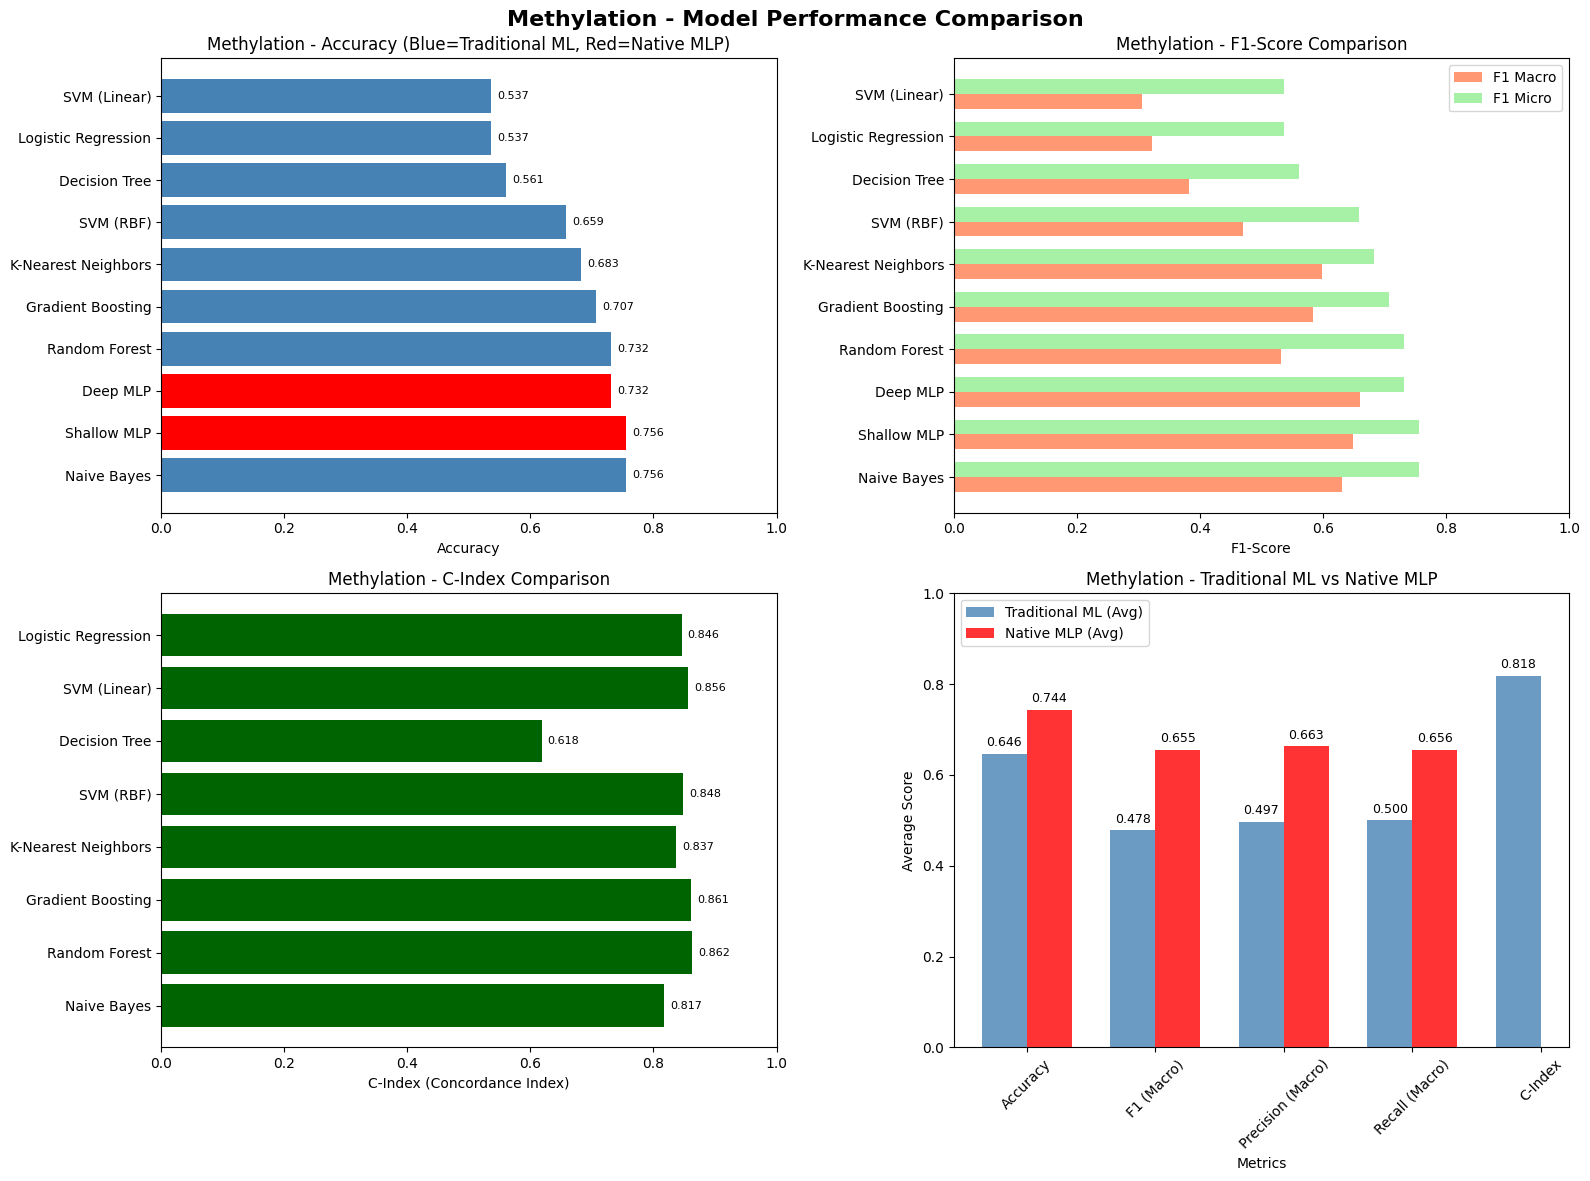


🏆 BEST MODEL FOR Methylation: Naive Bayes
   • Accuracy: 0.7561
   • F1-Macro: 0.6307
   • C-Index: 0.8167

🧬 COPY NUMBER VARIATION - COMPLETE RESULTS

📋 TRADITIONAL ML RESULTS - Copy Number Variation
----------------------------------------------------------------------------------------------------
              Model  Accuracy  Precision (Macro)  Precision (Micro)  Recall (Macro)  Recall (Micro)  F1 (Macro)  F1 (Micro)  C-Index
Logistic Regression  0.682927           0.431548           0.682927        0.477102        0.682927    0.439302    0.682927 0.806642
          SVM (RBF)  0.658537           0.440625           0.658537        0.486500        0.658537    0.455128    0.658537 0.827858
K-Nearest Neighbors  0.634146           0.735119           0.634146        0.541823        0.634146    0.543304    0.634146 0.749461
       SVM (Linear)  0.634146           0.393601           0.634146        0.450786        0.634146    0.412121    0.634146 0.799506
        Naive Bayes  0.634146   

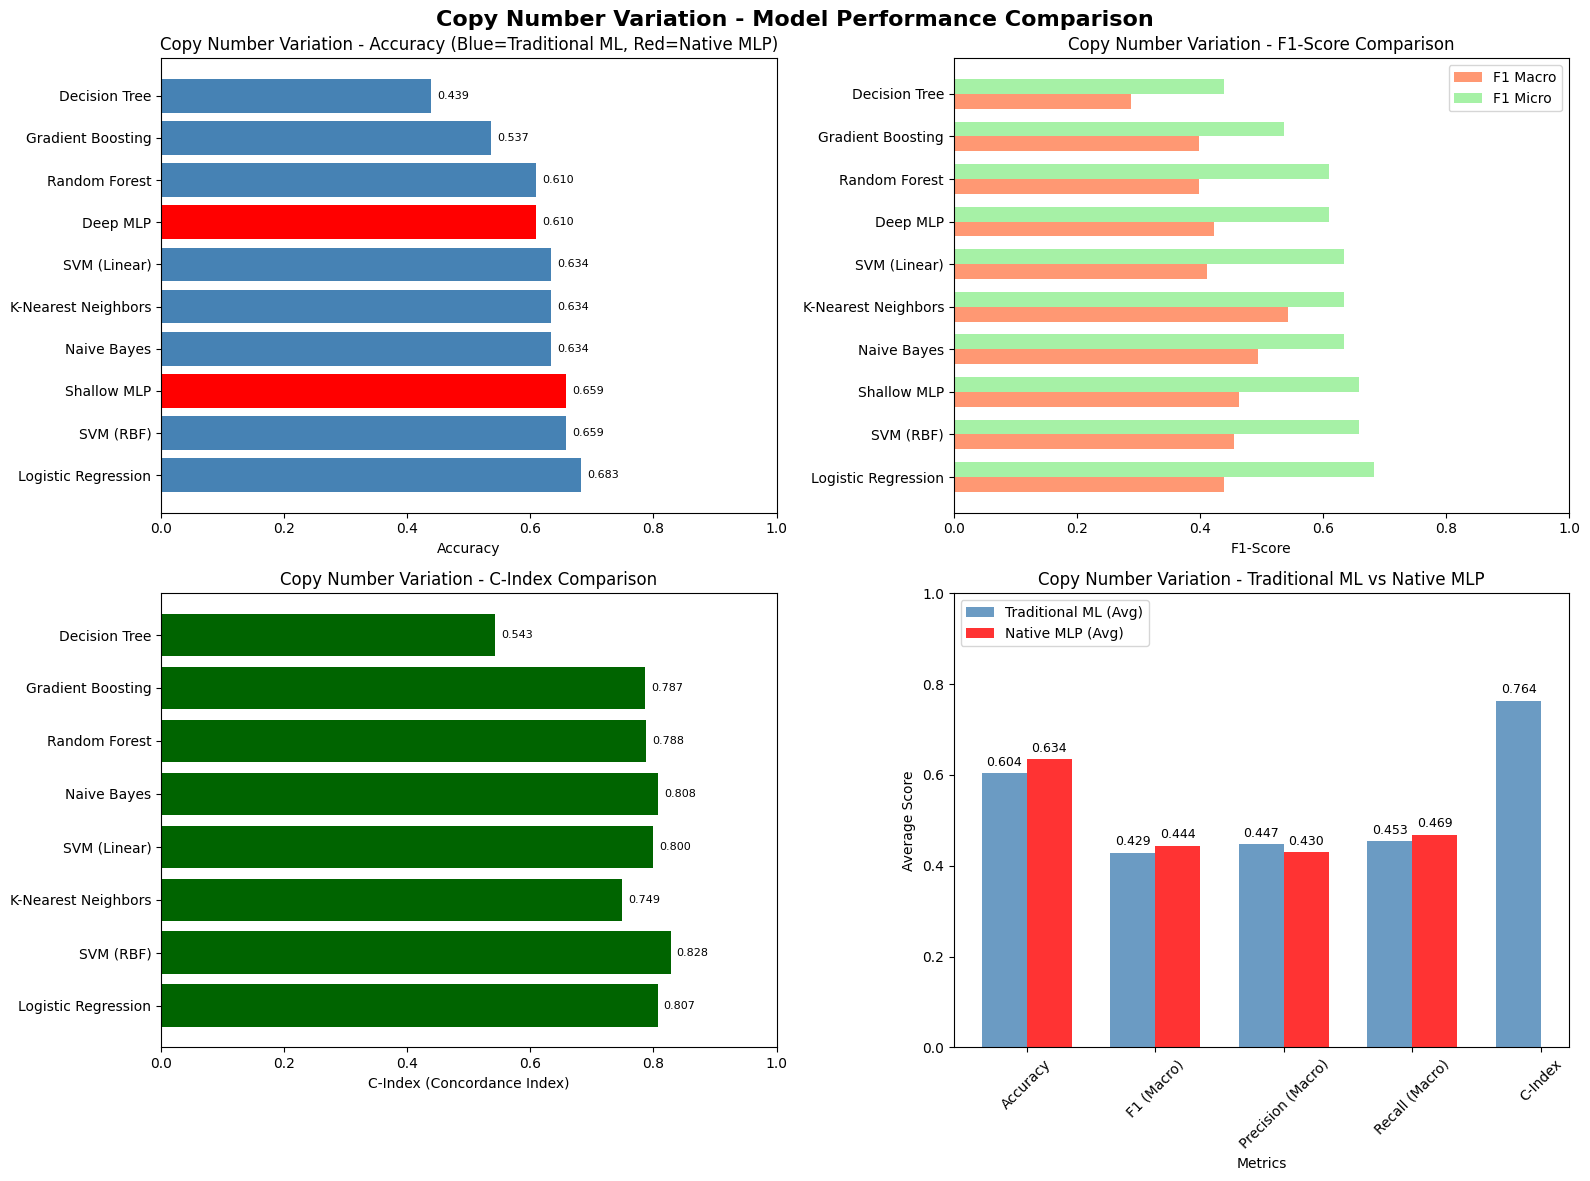


🏆 BEST MODEL FOR Copy Number Variation: Logistic Regression
   • Accuracy: 0.6829
   • F1-Macro: 0.4393
   • C-Index: 0.8066

✅ All individual omics results displayed!


In [12]:
# Comprehensive Results Display for Each Omic Separately
print("\n" + "="*100)
print("📊 COMPREHENSIVE RESULTS FOR EACH OMIC TYPE")
print("="*100)

# Display results for each omic separately
for omic_name in omics_data.keys():
    print(f"\n{'='*120}")
    print(f"🧬 {omic_name.upper()} - COMPLETE RESULTS")
    print(f"{'='*120}")
    
    # Get traditional ML results
    traditional_results = omic_results[omic_name]['results']
    traditional_df = pd.DataFrame(traditional_results)
    traditional_df = traditional_df.sort_values('Accuracy', ascending=False)
    
    # Get native MLP results
    mlp_results = omic_results[omic_name]['mlp_results']
    mlp_df = pd.DataFrame(mlp_results)
    
    # Combine results
    all_results = traditional_results + mlp_results
    combined_df = pd.DataFrame(all_results)
    combined_df = combined_df.sort_values('Accuracy', ascending=False)
    
    print(f"\n📋 TRADITIONAL ML RESULTS - {omic_name}")
    print("-" * 100)
    print(traditional_df.to_string(index=False))
    
    print(f"\n🤖 NATIVE MLP CLASSIFIER RESULTS - {omic_name}")
    print("-" * 100)
    print(mlp_df.to_string(index=False))
    
    print(f"\n🏆 COMBINED RANKING - {omic_name}")
    print("-" * 100)
    print(combined_df[['Model', 'Accuracy', 'F1 (Macro)', 'C-Index']].to_string(index=False))
    
    # Create visualization for this omic
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'{omic_name} - Model Performance Comparison', fontsize=16, fontweight='bold')
    
    # Separate traditional ML and MLP results for color coding
    traditional_ml = combined_df[~combined_df['Model'].str.contains('MLP')].copy()
    native_mlp = combined_df[combined_df['Model'].str.contains('MLP')].copy()
    
    # Plot 1: Accuracy comparison with color coding
    colors = ['steelblue' if 'MLP' not in model else 'red' for model in combined_df['Model']]
    bars1 = axes[0, 0].barh(combined_df['Model'], combined_df['Accuracy'], color=colors)
    axes[0, 0].set_xlabel('Accuracy')
    axes[0, 0].set_title(f'{omic_name} - Accuracy (Blue=Traditional ML, Red=Native MLP)')
    axes[0, 0].set_xlim([0, 1])
    
    # Add accuracy values on bars
    for i, (bar, acc) in enumerate(zip(bars1, combined_df['Accuracy'])):
        axes[0, 0].text(acc + 0.01, bar.get_y() + bar.get_height()/2, 
                        f'{acc:.3f}', va='center', fontsize=8)
    
    # Plot 2: F1-Score comparison
    x = np.arange(len(combined_df))
    width = 0.35
    bars2 = axes[0, 1].barh(x - width/2, combined_df['F1 (Macro)'], width, 
                            label='F1 Macro', color='coral', alpha=0.8)
    bars3 = axes[0, 1].barh(x + width/2, combined_df['F1 (Micro)'], width, 
                            label='F1 Micro', color='lightgreen', alpha=0.8)
    axes[0, 1].set_yticks(x)
    axes[0, 1].set_yticklabels(combined_df['Model'])
    axes[0, 1].set_xlabel('F1-Score')
    axes[0, 1].set_title(f'{omic_name} - F1-Score Comparison')
    axes[0, 1].legend()
    axes[0, 1].set_xlim([0, 1])
    
    # Plot 3: C-Index comparison (only for traditional ML)
    if 'C-Index' in traditional_df.columns:
        bars4 = axes[1, 0].barh(traditional_df['Model'], traditional_df['C-Index'], color='darkgreen')
        axes[1, 0].set_xlabel('C-Index (Concordance Index)')
        axes[1, 0].set_title(f'{omic_name} - C-Index Comparison')
        axes[1, 0].set_xlim([0, 1])
        # Add C-index values on bars
        for bar, c_idx in zip(bars4, traditional_df['C-Index']):
            axes[1, 0].text(c_idx + 0.01, bar.get_y() + bar.get_height()/2, f'{c_idx:.3f}', va='center', fontsize=8)
    
    # Plot 4: Model type performance summary
    available_metrics = ['Accuracy', 'F1 (Macro)', 'Precision (Macro)', 'Recall (Macro)']
    if 'C-Index' in traditional_df.columns:
        traditional_avg = traditional_ml[available_metrics + ['C-Index']].mean()
        mlp_avg = native_mlp[available_metrics].mean()
        categories = available_metrics + ['C-Index']
    else:
        traditional_avg = traditional_ml[available_metrics].mean()
        mlp_avg = native_mlp[available_metrics].mean()
        categories = available_metrics
    
    x_pos = np.arange(len(categories))
    width = 0.35
    
    bars5 = axes[1, 1].bar(x_pos - width/2, traditional_avg, width, 
                           label='Traditional ML (Avg)', color='steelblue', alpha=0.8)
    # Ensure mlp_avg and categories have the same length for plotting
    if len(mlp_avg) < len(categories):
        # Pad mlp_avg with np.nan to match categories length
        mlp_avg_padded = np.concatenate([mlp_avg.values, np.full(len(categories) - len(mlp_avg), np.nan)])
    else:
        mlp_avg_padded = mlp_avg.values[:len(categories)]
    bars6 = axes[1, 1].bar(x_pos + width/2, mlp_avg_padded, width, 
                           label='Native MLP (Avg)', color='red', alpha=0.8)
    
    axes[1, 1].set_xlabel('Metrics')
    axes[1, 1].set_ylabel('Average Score')
    axes[1, 1].set_title(f'{omic_name} - Traditional ML vs Native MLP')
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels(categories, rotation=45)
    axes[1, 1].legend()
    axes[1, 1].set_ylim([0, 1])
    
    # Add value labels on bars
    for bars in [bars5, bars6]:
        for bar in bars:
            height = bar.get_height()
            if not np.isnan(height):
                axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Best model for this omic
    best_model = combined_df.iloc[0]
    print(f"\n🏆 BEST MODEL FOR {omic_name}: {best_model['Model']}")
    print(f"   • Accuracy: {best_model['Accuracy']:.4f}")
    print(f"   • F1-Macro: {best_model['F1 (Macro)']:.4f}")
    if 'C-Index' in best_model:
        print(f"   • C-Index: {best_model['C-Index']:.4f}")

print(f"\n{'='*120}")
print("✅ All individual omics results displayed!")
print(f"{'='*120}")



In [13]:
# Cross-Validation Results for Each Omic (same as AE pipeline)
print("\n" + "="*100)
print("📊 CROSS-VALIDATION RESULTS (5-Fold Stratified) FOR EACH OMIC")
print("="*100)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for omic_name, omic_data in omics_data.items():
    print(f"\n{'='*100}")
    print(f"🔄 CROSS-VALIDATION: {omic_name}")
    print(f"{'='*100}")
    
    # Get top 3 traditional ML classifiers for this omic
    traditional_results = omic_results[omic_name]['results']
    traditional_df = pd.DataFrame(traditional_results)
    traditional_df = traditional_df.sort_values('Accuracy', ascending=False)
    top_3_models = traditional_df.head(3)
    
    classifiers = omic_results[omic_name]['classifiers']
    
    for _, model_row in top_3_models.iterrows():
        model_name = model_row['Model']
        clf = classifiers[model_name]
        
        scores = cross_val_score(clf, omic_data, labels, cv=cv, scoring='accuracy')
        f1_scores = cross_val_score(clf, omic_data, labels, cv=cv, scoring='f1_macro')
        roc_scores = cross_val_score(clf, omic_data, labels, cv=cv, scoring='roc_auc_ovr')
        
        print(f"{model_name}:")
        print(f"  Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")
        print(f"  F1-Macro: {f1_scores.mean():.4f} (+/- {f1_scores.std():.4f})")
        print(f"  C-Index:  {roc_scores.mean():.4f} (+/- {roc_scores.std():.4f})")
        print()

print("✅ Cross-validation completed for all omics!")


📊 CROSS-VALIDATION RESULTS (5-Fold Stratified) FOR EACH OMIC

🔄 CROSS-VALIDATION: Gene Expression
SVM (Linear):
  Accuracy: 0.7220 (+/- 0.0331)
  F1-Macro: 0.5885 (+/- 0.0628)
  C-Index:  0.8805 (+/- 0.0258)



f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATA

Logistic Regression:
  Accuracy: 0.6927 (+/- 0.0589)
  F1-Macro: 0.5233 (+/- 0.0682)
  C-Index:  0.8819 (+/- 0.0278)

Naive Bayes:
  Accuracy: 0.6683 (+/- 0.0569)
  F1-Macro: 0.5947 (+/- 0.0653)
  C-Index:  0.8565 (+/- 0.0408)


🔄 CROSS-VALIDATION: Methylation
Naive Bayes:
  Accuracy: 0.6390 (+/- 0.0714)
  F1-Macro: 0.5070 (+/- 0.0402)
  C-Index:  0.7948 (+/- 0.0466)

Random Forest:
  Accuracy: 0.6585 (+/- 0.0690)
  F1-Macro: 0.4914 (+/- 0.0517)
  C-Index:  0.8564 (+/- 0.0465)

Random Forest:
  Accuracy: 0.6585 (+/- 0.0690)
  F1-Macro: 0.4914 (+/- 0.0517)
  C-Index:  0.8564 (+/- 0.0465)

Gradient Boosting:
  Accuracy: 0.6146 (+/- 0.0943)
  F1-Macro: 0.4746 (+/- 0.1262)
  C-Index:  0.7923 (+/- 0.0638)


🔄 CROSS-VALIDATION: Copy Number Variation
Logistic Regression:
  Accuracy: 0.6732 (+/- 0.0569)
  F1-Macro: 0.4897 (+/- 0.0440)
  C-Index:  0.8100 (+/- 0.0708)

Gradient Boosting:
  Accuracy: 0.6146 (+/- 0.0943)
  F1-Macro: 0.4746 (+/- 0.1262)
  C-Index:  0.7923 (+/- 0.0638)


🔄 CROSS-VAL

f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATA

SVM (RBF):
  Accuracy: 0.6927 (+/- 0.0665)
  F1-Macro: 0.5043 (+/- 0.0483)
  C-Index:  0.8153 (+/- 0.0648)

K-Nearest Neighbors:
  Accuracy: 0.6000 (+/- 0.0749)
  F1-Macro: 0.4389 (+/- 0.0691)
  C-Index:  0.7321 (+/- 0.0550)

✅ Cross-validation completed for all omics!


In [14]:
# # Overall Summary Comparison Across All Omics
# print("\n" + "="*100)
# print("🌟 OVERALL SUMMARY: BEST PERFORMING MODEL PER OMIC")
# print("="*100)

# summary_results = []
# for omic_name in omics_data.keys():
#     # Get all results for this omic
#     traditional_results = omic_results[omic_name]['results']
#     mlp_results = omic_results[omic_name]['mlp_results']
#     all_results = traditional_results + mlp_results
#     all_df = pd.DataFrame(all_results)
    
#     # Get best model
#     best_model = all_df.loc[all_df['Accuracy'].idxmax()]
    
#     summary_results.append({
#         'Omic': omic_name,
#         'Best Model': best_model['Model'],
#         'Accuracy': best_model['Accuracy'],
#         'F1 (Macro)': best_model['F1 (Macro)'],
#         'Precision (Macro)': best_model['Precision (Macro)'],
#         'Recall (Macro)': best_model['Recall (Macro)']
#     })

# summary_df = pd.DataFrame(summary_results)
# summary_df = summary_df.sort_values('Accuracy', ascending=False)

# print("\n📋 BEST MODEL SUMMARY TABLE")
# print("-" * 100)
# print(summary_df.to_string(index=False))

# # Overall winner
# overall_winner = summary_df.iloc[0]
# print(f"\n🏆 OVERALL WINNER:")
# print(f"   Omic: {overall_winner['Omic']}")
# print(f"   Model: {overall_winner['Best Model']}")
# print(f"   Accuracy: {overall_winner['Accuracy']:.4f}")
# print(f"   F1-Macro: {overall_winner['F1 (Macro)']:.4f}")

# # Final comparison visualization
# fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# # Plot 1: Best accuracy per omic
# bars1 = axes[0].bar(summary_df['Omic'], summary_df['Accuracy'], 
#                    color=['lightcoral', 'lightblue', 'lightgreen'], alpha=0.8)
# axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
# axes[0].set_xlabel('Omic Type', fontsize=12, fontweight='bold')
# axes[0].set_title('Best Accuracy by Omic Type', fontsize=14, fontweight='bold')
# axes[0].set_ylim([0, 1])
# axes[0].grid(axis='y', alpha=0.3)
# plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')

# # Add value labels and model names
# for i, (bar, row) in enumerate(zip(bars1, summary_df.itertuples())):
#     axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
#                 f'{row.Accuracy:.3f}\n({row._2})', ha='center', va='bottom', fontsize=9)

# # Plot 2: F1-Macro scores
# bars2 = axes[1].bar(summary_df['Omic'], summary_df['F1 (Macro)'], 
#                    color=['lightcoral', 'lightblue', 'lightgreen'], alpha=0.8)
# axes[1].set_ylabel('F1-Macro Score', fontsize=12, fontweight='bold')
# axes[1].set_xlabel('Omic Type', fontsize=12, fontweight='bold')
# axes[1].set_title('Best F1-Macro by Omic Type', fontsize=14, fontweight='bold')
# axes[1].set_ylim([0, 1])
# axes[1].grid(axis='y', alpha=0.3)
# plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

# # Add value labels and model names
# for i, (bar, row) in enumerate(zip(bars2, summary_df.itertuples())):
#     axes[1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
#                 f'{row._5:.3f}\n({row._2})', ha='center', va='bottom', fontsize=9)

# plt.tight_layout()
# plt.show()

# # Export comprehensive results
# print("\n" + "="*100)
# print("💾 EXPORTING COMPREHENSIVE RESULTS")
# print("="*100)

# # Export individual omics embeddings
# for omic_name, omic_data in omics_data.items():
#     filename = f"{omic_name.lower().replace(' ', '_')}_mlp_embeddings.csv"
#     pd.DataFrame(omic_data).to_csv(filename, index=False)
#     print(f"✅ Exported: {filename}")

# # Export all results for each omic
# for omic_name in omics_data.keys():
#     # Traditional ML results
#     traditional_results = omic_results[omic_name]['results']
#     traditional_df = pd.DataFrame(traditional_results)
#     filename = f"{omic_name.lower().replace(' ', '_')}_traditional_ml_results.csv"
#     traditional_df.to_csv(filename, index=False)
    
#     # MLP results
#     mlp_results = omic_results[omic_name]['mlp_results']
#     mlp_df = pd.DataFrame(mlp_results)
#     filename = f"{omic_name.lower().replace(' ', '_')}_mlp_classifier_results.csv"
#     mlp_df.to_csv(filename, index=False)
    
#     # Combined results
#     all_results = traditional_results + mlp_results
#     combined_df = pd.DataFrame(all_results)
#     filename = f"{omic_name.lower().replace(' ', '_')}_combined_results.csv"
#     combined_df.to_csv(filename, index=False)

# # Export summary
# summary_df.to_csv("individual_omics_best_models_summary.csv", index=False)

# print("\n📋 EXPORTED FILES:")
# print("• Individual embeddings: *_mlp_embeddings.csv")
# print("• Traditional ML results: *_traditional_ml_results.csv") 
# print("• MLP classifier results: *_mlp_classifier_results.csv")
# print("• Combined results: *_combined_results.csv")
# print("• Overall summary: individual_omics_best_models_summary.csv")

# print("\n" + "="*100)
# print("🎉 INDIVIDUAL OMICS CLASSIFICATION ANALYSIS COMPLETE")
# print("="*100)
# print("✅ Successfully trained and evaluated individual omics using MLPs")
# print("✅ Applied same methodology as AE pipeline with same hyperparameters")
# print("✅ Trained both Traditional ML and Native MLP classifiers on each omic")
# print("✅ Generated comprehensive visualizations for each omic separately")
# print("✅ Performed cross-validation analysis for each omic")
# print("✅ Exported all results and embeddings")
# print("\n🔬 Ready for comparison with fused approach!")
# print("="*100)